In [1]:
import tensorflow as tf
import numpy as np
import gym
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

In [2]:
def discount(x, gamma=0.99):
    """
    Action take at timestep t can affect all rewards in future.
    Nearby rewards are most likely to be caused by actions, so we do a exponential decay.
    
    Given vector x, computes a vector y such that
    y[i] = x[i] + gamma * x[i+1] + gamma^2 x[i+2] + ...
    """
    out = np.zeros(len(x), 'float64')
    out[-1] = x[-1]
    for i in reversed(xrange(len(x)-1)):
        out[i] = x[i] + gamma*out[i+1]
    assert x.ndim >= 1
    # More efficient version:
    # scipy.signal.lfilter([1],[1,-gamma],x[::-1], axis=0)[::-1]
    return out

In [3]:
def categorical_sample(prob_n):
    """
    Weighted random sample given a discrete probability distribution
    """
    prob_n = np.asarray(prob_n)
    csprob_n = np.cumsum(prob_n)
    r = np.random.rand()
    return (csprob_n > r).argmax()

In [4]:
def calculate_advantages(list_of_rewards, discount_gamma):
    discouted_rewards = []
    for rewards in list_of_rewards:
        discouted_rewards.append(discount(rewards, gamma=discount_gamma))
    
    maxlen = max(len(rew) for rew in list_of_rewards)
    padded_rews = [np.concatenate([rew, np.zeros(maxlen-len(rew))]) for rew in discouted_rewards]
    # Compute time-dependent baseline
    baseline = np.mean(padded_rews, axis=0)
    # Compute advantage function
    advs = [rew - baseline[:len(rew)] for rew in discouted_rewards]
    return np.concatenate(advs)

In [6]:
img = None

def render_inline(image_array):
    global img
    if img is None:
        img = plt.imshow(image_array)
    else:
        img.set_data(image_array)
        display.display(plt.gcf())
        display.clear_output(wait=True)

In [61]:
def run_episode(agent, env, episode_max_length, render=False):
    """
    Run episode of environment and return results.
    """
    global img
    img = None
    ob = env.reset()
    obs = []
    acts = []
    rews = []
    actual_rews = []
    for _ in xrange(episode_max_length):
        a = agent.act(ob)
        (ob, rew, done, _) = env.step(a)
        
        obs.append(ob)
        acts.append(a)
        rews.append(rew)
        actual_rews.append(rew) 
        if done: break
        if render:
            x = env.render(mode='rgb_array')
            render_inline(x)
            
    # let's hack and say reward for each action is the maximum height achieved in future states
    height_rewards = [obs[-1][0]]
    max_so_far_height = obs[-1][0]
    for i in xrange(len(actual_rews) - 2, -1, -1):
        max_so_far_height = max(max_so_far_height, obs[i][0])
        height_rewards.append(max_so_far_height)
    height_rewards = np.array(list(reversed(height_rewards)))
    
    velocity_rewards = [abs(obs[-1][1])]
    max_so_far_velocity = abs(obs[-1][1])
    for i in xrange(len(actual_rews) - 2, -1, -1):
        max_so_far_velocity = max(max_so_far_velocity, abs(obs[i][1]))
        velocity_rewards.append(max_so_far_velocity)
    velocity_rewards = np.array(list(reversed(velocity_rewards)))
                         
    hacked_rewards = height_rewards * 0.5 + velocity_rewards * 0.5
    
    return {
        "reward" : hacked_rewards,
        "ob" : np.array(obs),
        "action" : np.array(acts),
        "actual_reward": np.array(actual_rews),
    }

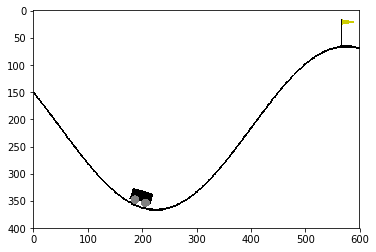

In [62]:
class DummyAgent:
    def __init__(self, env):
        self.env = env
        
    def act(self, _ob):
        return env.action_space.sample()

env = gym.make('MountainCar-v0')
x = run_episode(DummyAgent(env), env, env.spec.max_episode_steps, render=True)

In [63]:
x["ob"]

array([[ -5.87554656e-01,   1.48767956e-03],
       [ -5.85590245e-01,   1.96441105e-03],
       [ -5.83163573e-01,   2.42667162e-03],
       [ -5.81292539e-01,   1.87103389e-03],
       [ -5.79990960e-01,   1.30157992e-03],
       [ -5.79268453e-01,   7.22506709e-04],
       [ -5.77130362e-01,   2.13809107e-03],
       [ -5.73592507e-01,   3.53785442e-03],
       [ -5.68681104e-01,   4.91140327e-03],
       [ -5.64432613e-01,   4.24849088e-03],
       [ -5.60878634e-01,   3.55397926e-03],
       [ -5.58045638e-01,   2.83299569e-03],
       [ -5.53954751e-01,   4.09088757e-03],
       [ -5.49636508e-01,   4.31824282e-03],
       [ -5.46123181e-01,   3.51332728e-03],
       [ -5.42441049e-01,   3.68213179e-03],
       [ -5.37617675e-01,   4.82337359e-03],
       [ -5.33689191e-01,   3.92848434e-03],
       [ -5.28685040e-01,   5.00415090e-03],
       [ -5.23642744e-01,   5.04229640e-03],
       [ -5.17600117e-01,   6.04262616e-03],
       [ -5.10602479e-01,   6.99763865e-03],
       [ -

In [64]:
x["reward"]

array([-0.15959069, -0.15959069, -0.15959069, -0.15959069, -0.15959069,
       -0.15959069, -0.15959069, -0.15959069, -0.15959069, -0.15959069,
       -0.15959069, -0.15959069, -0.15959069, -0.15959069, -0.15959069,
       -0.15959069, -0.15959069, -0.15959069, -0.15959069, -0.15959069,
       -0.15959069, -0.15959069, -0.15959069, -0.15959069, -0.15959069,
       -0.15959069, -0.15959069, -0.15959069, -0.15959069, -0.15959069,
       -0.15959069, -0.15959069, -0.15959069, -0.15959069, -0.15959069,
       -0.15959069, -0.15959069, -0.15959069, -0.15959069, -0.15959069,
       -0.15959069, -0.15959069, -0.15959069, -0.15959069, -0.15959069,
       -0.15959069, -0.15959069, -0.15959069, -0.15959069, -0.15959069,
       -0.15959069, -0.15959069, -0.15959069, -0.15959069, -0.15959069,
       -0.15959069, -0.15959069, -0.15959069, -0.15959069, -0.15959069,
       -0.15959069, -0.15959069, -0.15959069, -0.15959069, -0.15959069,
       -0.15959069, -0.15959069, -0.15959069, -0.15959069, -0.15

In [42]:
x["actual_reward"]

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1

In [65]:
env.spec.max_episode_steps

200

In [66]:
def declare_variables(env, num_hidden):
    W0 = tf.get_variable(
        "W0",
        [env.observation_space.shape[0], num_hidden],
        initializer = tf.contrib.layers.xavier_initializer(),
    )
    b0 = tf.get_variable(
        "b0",
        [num_hidden]
    )
    W1 = tf.get_variable(
        "W1", 
        [num_hidden, env.action_space.n],
        initializer=tf.contrib.layers.xavier_initializer(),
    )
    b1 = tf.get_variable("b1", [env.action_space.n])
    return [W0, b0, W1, b1]
    

class PolicyGradientAgent:
    def __init__(self, env, learning_rate=0.001, num_hidden=8):
        self.X = tf.placeholder(dtype=tf.float32, shape=[None, env.observation_space.shape[0]], name="X")
        
        self.Adv = tf.placeholder(dtype=tf.float32, shape=[None, 1], name="Adv")
        self.Actions = tf.placeholder(dtype=tf.int32, shape=[None, 2], name="Actions")
        
        self.W0, self.b0, self.W1, self.b1 = declare_variables(env, num_hidden)
        
        self.hidden = tf.nn.relu(tf.add(tf.matmul(self.X, self.W0), self.b0))
        self.probs = tf.nn.softmax(tf.add(tf.matmul(self.hidden, self.W1), self.b1))
        
        action_probs = tf.expand_dims(tf.gather_nd(self.probs, self.Actions), 1)
        policy_advantage = tf.reduce_mean(tf.multiply(tf.log(action_probs), self.Adv))
        self.optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(-policy_advantage)
        
        self.saver = tf.train.Saver()
        self.params = None
        
    def set_params(self, params):
        self.params = params
        
    def _numpy_softmax(self, X):
        W0, b0, W1, b1 = self.params
        hidden = np.dot(X, W0) + b0
        hidden[hidden < 0.] = 0.
        output_pre = np.dot(hidden, W1) + b1
        softmax = np.exp(output_pre)
        softmax /= softmax.sum()
        return softmax
        
    def save(self, sess, filename):
        return self.saver.save(sess, filename)
        
    def restore(self, sess, filename):
        self.saver.restore(sess, filename)
        
    def act(self, ob):
        action_probs = self._numpy_softmax(np.array([ob]))
        action = categorical_sample(action_probs[0])
        return action
    
    def learn(self, sess, all_obs, all_actions, all_advantages):
        result = sess.run(
            self.optimizer,
            feed_dict={
                self.X: all_obs,
                self.Actions: np.hstack([np.arange(all_actions.shape[0])[:, None], all_actions[:, None]]),
                self.Adv: all_advantages[:, None],
            },
        )

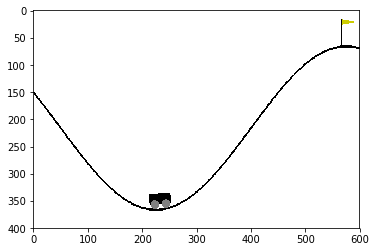

In [67]:
tf.reset_default_graph()
with tf.Session() as sess:
    agent = PolicyGradientAgent(env)
    init = tf.global_variables_initializer()
    sess.run(init)
    
    params = sess.run([agent.W0, agent.b0, agent.W1, agent.b1])
    agent.set_params(params)
    
    x = run_episode(agent, env, env.spec.max_episode_steps, render=True)

In [68]:
def run_single_iteration(sess, batch_size, discount_gamma, print_summary=False):
    results = []
    for _ in xrange(batch_size):
        results.append(run_episode(agent, env, env.spec.max_episode_steps, render=False))
        
    all_obs = np.concatenate([x["ob"] for x in results])
    all_actions = np.concatenate([x["action"] for x in results])
    all_advs = calculate_advantages([x["reward"] for x in results], discount_gamma)
    
    agent.learn(sess, all_obs, all_actions, all_advs)
    agent.set_params(sess.run([agent.W0, agent.b0, agent.W1, agent.b1]))
    
    if print_summary:
        print("Maximum weighted reward %f, Average weighted reward: %f, Std dev weighted reward: %f" % (
                max(x["reward"].max() for x in results),
                np.concatenate([x["reward"] for x in results]).mean(),
                np.concatenate([x["reward"] for x in results]).std(),
            )
        )
        print("Maximum episode length %d, Average episode length: %f, Std dev episode length: %f" % (
                max(len(x["reward"]) for x in results),
                np.array([len(x["reward"]) for x in results]).mean(),
                np.array([len(x["reward"]) for x in results]).std(),
            )
        )
        print("Maximum actual reward %d, Average actual rewards: %f, Std dev actual rewards: %f" % (
                max(x["actual_reward"].sum() for x in results),
                np.array([x["actual_reward"].sum() for x in results]).mean(),
                np.array([x["actual_reward"].sum() for x in results]).std(),
            )
        )
        print("Maximum height %f, Average height: %f, Std dev height: %f" % (
                max(x["ob"][:, 0].max() for x in results),
                np.concatenate([x["ob"][:, 0] for x in results]).mean(),
                np.concatenate([x["ob"][:, 0] for x in results]).std(),
            )
        )
        print("Maximum velocity %f, Average velocity: %f, Std dev velocity: %f" % (
                max(np.abs(x["ob"][:, 1]).max() for x in results),
                np.concatenate([np.abs(x["ob"][:, 1]) for x in results]).mean(),
                np.concatenate([np.abs(x["ob"][:, 1]) for x in results]).std(),
            )
        )
    return np.concatenate([x["reward"] for x in results]).mean()


tf.reset_default_graph()
with tf.Session() as sess:
    agent = PolicyGradientAgent(env, learning_rate=0.001)
    init = tf.global_variables_initializer()
    sess.run(init)
    
    agent.set_params(sess.run([agent.W0, agent.b0, agent.W1, agent.b1]))
    
    print(agent.params[0][0][0])
    run_single_iteration(sess, batch_size=50, discount_gamma=0.9, print_summary=True)
    print(agent.params[0][0][0])

0.489383
Maximum weighted reward -0.170769, Average weighted reward: -0.220349, Std dev weighted reward: 0.021546
Maximum episode length 200, Average episode length: 200.000000, Std dev episode length: 0.000000
Maximum actual reward -200, Average actual rewards: -200.000000, Std dev actual rewards: 0.000000
Maximum height -0.356095, Average height: -0.513365, Std dev height: 0.047830
Maximum velocity 0.014558, Average velocity: 0.003308, Std dev velocity: 0.002516
0.489383


In [90]:
config = {
    'num_iterations': 10000,
    'batch_size': 100,
    'learning_rate': 0.01,
    'discount_gamma': 0.99,
    'num_hidden': 32,
}

def do_training(agent, sess):
    average_rewards = []
    for i in xrange(config['num_iterations']):
        print_summary = (i > 0 and i % 100 == 0) or i == config["num_iterations"] - 1
        if print_summary:
            print("------------------Iteration %d--------------------------" % i)

        avg_reward = run_single_iteration(
            sess,
            batch_size=config['batch_size'],
            discount_gamma=config['discount_gamma'],
            print_summary=print_summary,
        )
        average_rewards.append(avg_reward)
        if print_summary:
            print("-----------------------------------------------------")
        if (i > 0 and i % 100 == 0) or i == config["num_iterations"] - 1:
            save_path = agent.save(sess, "/tmp/mountain_car_pg.chkpt")
            print(agent.params[0][0][0])
            print("Model saved in file: %s" % save_path)

    return np.array(average_rewards)
    
    
tf.reset_default_graph()
with tf.Session() as sess:
    tf_session = sess
    agent = PolicyGradientAgent(env, learning_rate=config['learning_rate'], num_hidden=config['num_hidden'])
    init = tf.global_variables_initializer()
    sess.run(init)
    agent.set_params(sess.run([agent.W0, agent.b0, agent.W1, agent.b1]))
    
    average_rewards = do_training(agent, sess)

------------------Iteration 100--------------------------
Maximum weighted reward -0.078924, Average weighted reward: -0.176928, Std dev weighted reward: 0.039858
Maximum episode length 200, Average episode length: 200.000000, Std dev episode length: 0.000000
Maximum actual reward -200, Average actual rewards: -200.000000, Std dev actual rewards: 0.000000
Maximum height -0.181522, Average height: -0.478818, Std dev height: 0.078919
Maximum velocity 0.024690, Average velocity: 0.005188, Std dev velocity: 0.004184
-----------------------------------------------------
-0.255032
Model saved in file: /tmp/mountain_car_pg.chkpt
------------------Iteration 200--------------------------
Maximum weighted reward -0.062045, Average weighted reward: -0.127904, Std dev weighted reward: 0.037335
Maximum episode length 200, Average episode length: 200.000000, Std dev episode length: 0.000000
Maximum actual reward -200, Average actual rewards: -200.000000, Std dev actual rewards: 0.000000
Maximum heig

Maximum weighted reward 0.291564, Average weighted reward: 0.050090, Std dev weighted reward: 0.166476
Maximum episode length 200, Average episode length: 199.830000, Std dev episode length: 0.949263
Maximum actual reward -191, Average actual rewards: -199.830000, Std dev actual rewards: 0.949263
Maximum height 0.531801, Average height: -0.558983, Std dev height: 0.298300
Maximum velocity 0.051328, Average velocity: 0.013554, Std dev velocity: 0.010933
-----------------------------------------------------
-0.613825
Model saved in file: /tmp/mountain_car_pg.chkpt
------------------Iteration 1500--------------------------
Maximum weighted reward 0.291834, Average weighted reward: 0.104663, Std dev weighted reward: 0.178982
Maximum episode length 200, Average episode length: 198.570000, Std dev episode length: 3.244241
Maximum actual reward -186, Average actual rewards: -198.570000, Std dev actual rewards: 3.244241
Maximum height 0.532620, Average height: -0.544369, Std dev height: 0.3285

------------------Iteration 2800--------------------------
Maximum weighted reward 0.272604, Average weighted reward: 0.066979, Std dev weighted reward: 0.144464
Maximum episode length 200, Average episode length: 200.000000, Std dev episode length: 0.000000
Maximum actual reward -200, Average actual rewards: -200.000000, Std dev actual rewards: 0.000000
Maximum height 0.503903, Average height: -0.552160, Std dev height: 0.326802
Maximum velocity 0.048208, Average velocity: 0.014818, Std dev velocity: 0.011159
-----------------------------------------------------
-0.331332
Model saved in file: /tmp/mountain_car_pg.chkpt
------------------Iteration 2900--------------------------
Maximum weighted reward 0.286000, Average weighted reward: 0.128883, Std dev weighted reward: 0.131300
Maximum episode length 200, Average episode length: 199.110000, Std dev episode length: 4.865994
Maximum actual reward -154, Average actual rewards: -199.110000, Std dev actual rewards: 4.865994
Maximum height 

Maximum weighted reward 0.287914, Average weighted reward: 0.117676, Std dev weighted reward: 0.141817
Maximum episode length 200, Average episode length: 199.460000, Std dev episode length: 1.615054
Maximum actual reward -192, Average actual rewards: -199.460000, Std dev actual rewards: 1.615054
Maximum height 0.527997, Average height: -0.542061, Std dev height: 0.338692
Maximum velocity 0.051143, Average velocity: 0.015334, Std dev velocity: 0.011890
-----------------------------------------------------
-0.976457
Model saved in file: /tmp/mountain_car_pg.chkpt
------------------Iteration 4200--------------------------
Maximum weighted reward 0.281566, Average weighted reward: 0.081962, Std dev weighted reward: 0.133440
Maximum episode length 200, Average episode length: 199.790000, Std dev episode length: 1.733753
Maximum actual reward -183, Average actual rewards: -199.790000, Std dev actual rewards: 1.733753
Maximum height 0.516098, Average height: -0.551136, Std dev height: 0.3303

------------------Iteration 5500--------------------------
Maximum weighted reward 0.154473, Average weighted reward: -0.054805, Std dev weighted reward: 0.122071
Maximum episode length 200, Average episode length: 200.000000, Std dev episode length: 0.000000
Maximum actual reward -200, Average actual rewards: -200.000000, Std dev actual rewards: 0.000000
Maximum height 0.268045, Average height: -0.562479, Std dev height: 0.250644
Maximum velocity 0.040902, Average velocity: 0.011697, Std dev velocity: 0.009133
-----------------------------------------------------
-1.08942
Model saved in file: /tmp/mountain_car_pg.chkpt
------------------Iteration 5600--------------------------
Maximum weighted reward 0.185116, Average weighted reward: -0.092411, Std dev weighted reward: 0.134857
Maximum episode length 200, Average episode length: 200.000000, Std dev episode length: 0.000000
Maximum actual reward -200, Average actual rewards: -200.000000, Std dev actual rewards: 0.000000
Maximum height

Maximum weighted reward 0.282342, Average weighted reward: -0.033518, Std dev weighted reward: 0.152876
Maximum episode length 200, Average episode length: 199.960000, Std dev episode length: 0.397995
Maximum actual reward -196, Average actual rewards: -199.960000, Std dev actual rewards: 0.397995
Maximum height 0.518522, Average height: -0.537944, Std dev height: 0.261070
Maximum velocity 0.047202, Average velocity: 0.011459, Std dev velocity: 0.009782
-----------------------------------------------------
-1.07374
Model saved in file: /tmp/mountain_car_pg.chkpt
------------------Iteration 6900--------------------------
Maximum weighted reward 0.254351, Average weighted reward: -0.046297, Std dev weighted reward: 0.156450
Maximum episode length 200, Average episode length: 200.000000, Std dev episode length: 0.000000
Maximum actual reward -200, Average actual rewards: -200.000000, Std dev actual rewards: 0.000000
Maximum height 0.462877, Average height: -0.551854, Std dev height: 0.257

------------------Iteration 8200--------------------------
Maximum weighted reward -0.061286, Average weighted reward: -0.228699, Std dev weighted reward: 0.080342
Maximum episode length 200, Average episode length: 200.000000, Std dev episode length: 0.000000
Maximum actual reward -200, Average actual rewards: -200.000000, Std dev actual rewards: 0.000000
Maximum height -0.149463, Average height: -0.612090, Std dev height: 0.160689
Maximum velocity 0.029612, Average velocity: 0.006809, Std dev velocity: 0.005053
-----------------------------------------------------
-1.56866
Model saved in file: /tmp/mountain_car_pg.chkpt
------------------Iteration 8300--------------------------
Maximum weighted reward 0.012524, Average weighted reward: -0.154080, Std dev weighted reward: 0.077203
Maximum episode length 200, Average episode length: 200.000000, Std dev episode length: 0.000000
Maximum actual reward -200, Average actual rewards: -200.000000, Std dev actual rewards: 0.000000
Maximum heig

Maximum weighted reward 0.281541, Average weighted reward: 0.241731, Std dev weighted reward: 0.020802
Maximum episode length 200, Average episode length: 199.630000, Std dev episode length: 1.566238
Maximum actual reward -188, Average actual rewards: -199.630000, Std dev actual rewards: 1.566238
Maximum height 0.510315, Average height: -0.436056, Std dev height: 0.463517
Maximum velocity 0.063115, Average velocity: 0.020900, Std dev velocity: 0.016228
-----------------------------------------------------
-1.35743
Model saved in file: /tmp/mountain_car_pg.chkpt
------------------Iteration 9600--------------------------
Maximum weighted reward 0.284253, Average weighted reward: 0.260250, Std dev weighted reward: 0.031991
Maximum episode length 200, Average episode length: 196.780000, Std dev episode length: 5.181853
Maximum actual reward -181, Average actual rewards: -196.780000, Std dev actual rewards: 5.181853
Maximum height 0.514238, Average height: -0.426889, Std dev height: 0.47138

Text(0,0.5,u'Average reward')

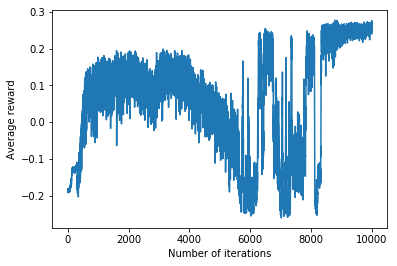

In [91]:
plt.plot(np.arange(average_rewards.shape[0]), average_rewards)
plt.xlabel('Number of iterations')
plt.ylabel('Average reward')

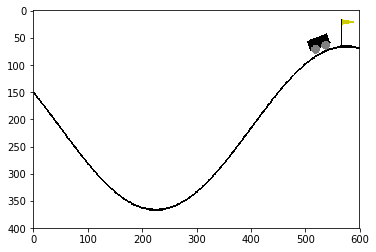

In [94]:
res = run_episode(agent, env, env.spec.max_episode_steps, render=True)

In [16]:
env.observation_space.low.sh

array([-1.2 , -0.07])

In [17]:
env.observation_space.high

array([ 0.6 ,  0.07])